In [1]:
import os; os.environ['OPENBLAS_NUM_THREADS']='1'

In [3]:
!pip install implicit

     |████████████████████████████████| 8.9 MB 17.8 MB/s            


In [4]:
import numpy as np
import pandas as pd
import implicit
from scipy.sparse import coo_matrix
from implicit.evaluation import mean_average_precision_at_k

In [6]:
transactions_df = pd.read_csv("data/transactions_sm.csv")

In [7]:
customers_df = pd.read_csv('data/customers_sm.csv')
articles_df = pd.read_csv('data/articles_sm.csv')

In [20]:
customers_org = pd.read_csv('customers.csv')


In [8]:
start_date = pd.to_datetime('2020-07-01')
end_date = pd.to_datetime('2020-09-22')

# Filter transactions by date
transactions_df.t_dat = pd.to_datetime(transactions_df.t_dat)
transactions_df = transactions_df.loc[transactions_df.t_dat >= start_date]
transactions_df = transactions_df.loc[transactions_df.t_dat < end_date]

In [9]:
pd.options.display.max_rows = 50
customers_df

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,common_postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,0.0,False,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,False
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,0.0,False,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,False
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,0.0,False,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,False
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,0.0,False,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,False
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,False,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,False
...,...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,0.0,False,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...,False
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,0.0,False,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...,False
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,False,Regularly,21.0,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...,False
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,False,Regularly,18.0,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...,False


In [10]:
customers_df.shape[0] - customers_df['customer_id'].nunique()

0

In [11]:
data_postal = customers_df.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
data_postal.head()

,postal_code,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,common_postal_code
61034,2c29ae653a9282cce4151bd87643c907644e09541abc28...,120303,42874,120303,120303,114377,120303,120303
281937,cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac...,261,109,261,261,261,261,261
156090,714976379549eb90aae4a71bca6c7402cc646ae7c40f6c...,159,90,159,159,159,159,159
171208,7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5...,157,55,157,157,156,157,157
126228,5b7eb31eabebd3277de632b82267286d847fd5d44287ee...,156,42,156,156,156,156,156


In [12]:
customers_df[customers_df['postal_code']=='2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c'].head(5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,common_postal_code
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,0.0,False,NaN,36.386965,2c29ae653a9282cce4151bd87643c907644e09541abc28...,True
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,0.0,False,NONE,20.000000,2c29ae653a9282cce4151bd87643c907644e09541abc28...,True
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,0.0,False,NONE,20.000000,2c29ae653a9282cce4151bd87643c907644e09541abc28...,True
11,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,NaN,0.0,False,NONE,31.000000,2c29ae653a9282cce4151bd87643c907644e09541abc28...,True
14,0000ae1bbb25e04bdc7e35f718e852adfb3fbb72ef38b3...,1.0,1.0,False,Regularly,29.000000,2c29ae653a9282cce4151bd87643c907644e09541abc28...,True


In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


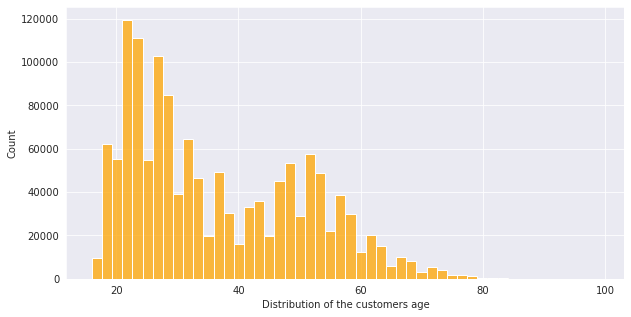

In [14]:

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers_df, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

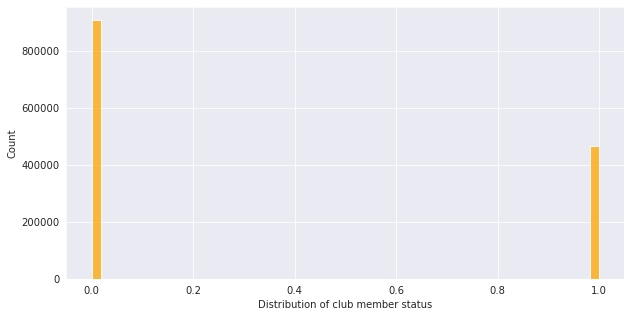

In [28]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers_df, x='Active', color='orange')
ax.set_xlabel('Distribution of club member status')
plt.show()

In [20]:
customers_df['fashion_news_frequency'].head()

0         None
1         None
2         None
3         None
4    Regularly
Name: fashion_news_frequency, dtype: object

In [21]:
customers_df['fashion_news_frequency'].value_counts()

fashion_news_frequency
None         893722
Regularly    477416
Monthly         842
Name: count, dtype: int64

In [19]:
customers_df.loc[~customers_df['fashion_news_frequency'].isin(['Regularly', 'Monthly']), 'fashion_news_frequency'] = 'None'
customers_df['fashion_news_frequency'].unique()

array(['None', 'Regularly', 'Monthly'], dtype=object)

In [22]:
pie_data = customers_df[['customer_id', 'fashion_news_frequency']].groupby('fashion_news_frequency').count()

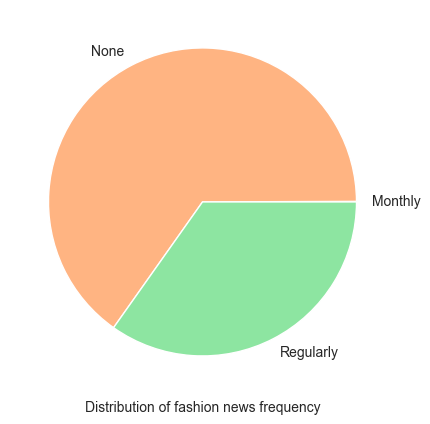

In [23]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
# ax = sns.histplot(data=customers, x='fashion_news_frequency', color='orange')
# ax = sns.pie(data=customers, x='fashion_news_frequency', color='orange')
colors = sns.color_palette('pastel')
ax.pie(pie_data.customer_id, labels=pie_data.index, colors = colors)
ax.set_facecolor('lightgrey')
ax.set_xlabel('Distribution of fashion news frequency')
plt.show()

In [24]:
transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
28401361,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,825577003,0.013542,2
28401362,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,849487005,0.042356,2
28401363,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,772659001,0.023712,2
28401364,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,804732004,0.042356,2
28401365,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,804732004,0.042356,2


In [26]:
pd.set_option('display.float_format', '{:.4f}'.format)
transactions_df.describe()['price']

count   3354097.0000
mean          0.0272
min           0.0001
25%           0.0155
50%           0.0254
75%           0.0339
max           0.5068
std           0.0185
Name: price, dtype: float64

In [27]:
transactions_byid = transactions_df.groupby('customer_id').count()

In [28]:
transactions_byid.sort_values(by='price', ascending=False)['price'][:10]

customer_id
b637a3e7d8b0caa947aaefd609b8d84a9ee962cf0a52a51bac507ffc2bf1b741    316
4308983955108b3af43ec57f0557211e44462a5633238351fff14c8b51f16093    299
a3ab708684132c6bbd3dad7aa41f9b9c7d1c95d7d5cb1a3a052905191e858566    294
67931690bdf18d2e328854ae772cd5ce2505fdc11164693998b13e706db0bb56    259
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    246
4043fdbe22eb397206dabf520d2d88651179724ac19ccf6e69efadfd3da530b6    236
9150085d4efd2dcfdb954180217ce6c2b6e3399963fb19daef2cf6078a77903e    235
4de6988c4971cfc0c6910a85a54fa8d6fb11be64b87b98c46b73821d7db07ce7    231
d80ed4ababfa96812e22b911629e6bcbf5093769051ea447e2b696ac98a3dae9    225
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    222
Name: price, dtype: int64

In [30]:
articles_for_merge = articles_df[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name']]

In [31]:
articles_for_merge = transactions_df[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_for_merge, on='article_id', how='left')

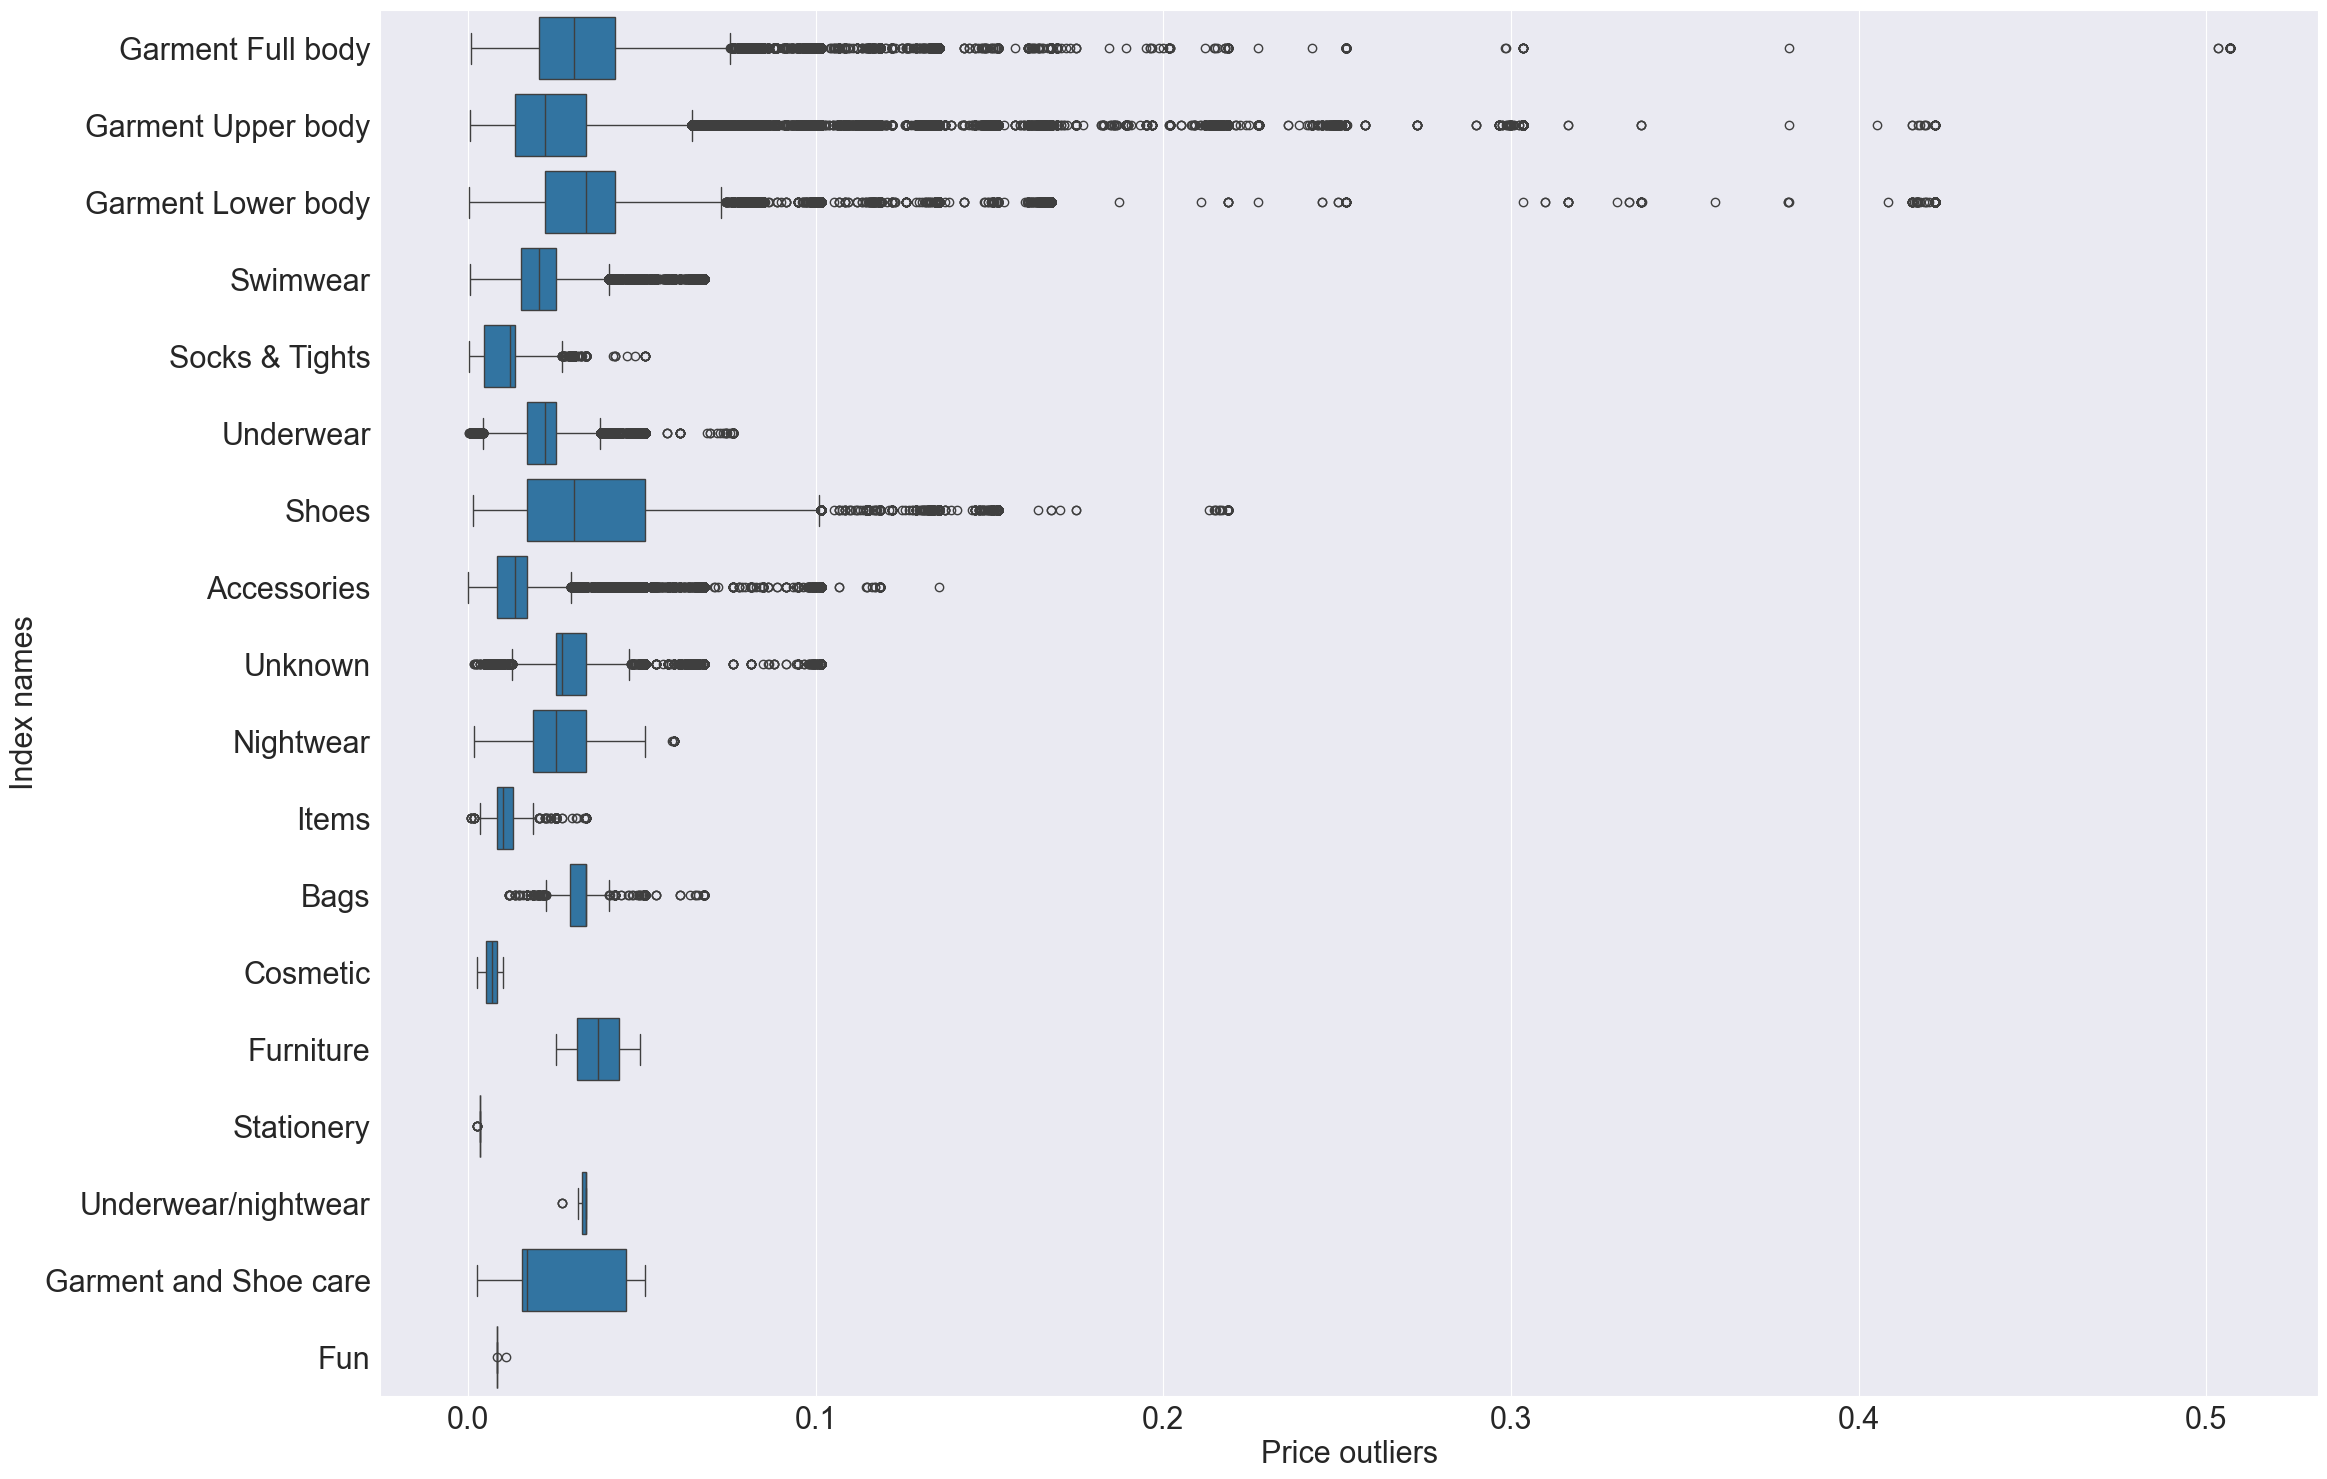

In [32]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(25,18))
ax = sns.boxplot(data=articles_for_merge, x='price', y='product_group_name')
ax.set_xlabel('Price outliers', fontsize=22)
ax.set_ylabel('Index names', fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

plt.show()

In [33]:
articles_for_merge.head()

,customer_id,article_id,price,t_dat,prod_name,product_type_name,product_group_name,index_name
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,825577003,0.0135,2020-07-01,PIXI TSHIRT DRESS,Dress,Garment Full body,Ladieswear
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,849487005,0.0424,2020-07-01,Seb overshirt,Jacket,Garment Upper body,Ladieswear
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,772659001,0.0237,2020-07-01,Ruby shorts,Shorts,Garment Lower body,Ladieswear
3,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,804732004,0.0424,2020-07-01,Durham joggers(1),Trousers,Garment Lower body,Ladieswear
4,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,804732004,0.0424,2020-07-01,Durham joggers(1),Trousers,Garment Lower body,Ladieswear


In [34]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


# Benchmark Model : Matrix Factorization - ALS 

In [29]:
ALL_USERS = customers_df['customer_id'].unique().tolist()
ALL_ITEMS = articles_df['article_id'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

transactions_df['user_id'] = transactions_df['customer_id'].map(user_map)
transactions_df['item_id'] = transactions_df['article_id'].map(item_map)

## sparse matrix

In [30]:
row = transactions_df['user_id'].values
col = transactions_df['item_id'].values
data = np.ones(transactions_df.shape[0])
coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
coo_train

<1371980x105542 sparse matrix of type '<class 'numpy.float64'>'
	with 2560477 stored elements in COOrdinate format>

- test

In [31]:
%%time
model = implicit.als.AlternatingLeastSquares(factors=10, iterations=2)
model.fit(coo_train)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/implicit/cpu/als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/implicit/utils.py:167: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.2032604217529297 seconds
  ParameterWarning,


  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 17.8 s, sys: 160 ms, total: 18 s
Wall time: 3.8 s


In [37]:
def to_user_item_coo(df):
    """ Turn a dataframe with transactions into a COO sparse items x users matrix"""
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    return coo


def split_data(df, validation_days=7):
    """ Split a pandas dataframe into training and validation data, using <<validation_days>>
    """
    validation_cut = df['t_dat'].max() - pd.Timedelta(validation_days)

    df_train = df[df['t_dat'] < validation_cut]
    df_val = df[df['t_dat'] >= validation_cut]
    return df_train, df_val

def get_val_matrices(df, validation_days=7):
    """ Split into training and validation and create various matrices
        
        Returns a dictionary with the following keys:
            coo_train: training data in COO sparse format and as (users x items)
            csr_train: training data in CSR sparse format and as (users x items)
            csr_val:  validation data in CSR sparse format and as (users x items)
    
    """
    df_train, df_val = split_data(df, validation_days=validation_days)
    coo_train = to_user_item_coo(df_train)
    coo_val = to_user_item_coo(df_val)

    csr_train = coo_train.tocsr()
    csr_val = coo_val.tocsr()
    
    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_val': csr_val
          }


def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    """ Train an ALS model with <<factors>> (embeddings dimension) 
    for <<iterations>> over matrices and validate with MAP@12
    """
    coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization,
                                                 calculate_training_loss=True,
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    
    # The MAPK by implicit doesn't allow to calculate allowing repeated items, which is the case.
    # TODO: change MAP@12 to a library that allows repeated items in prediction
    map12 = mean_average_precision_at_k(model, csr_train, csr_val, K=12, show_progress=show_progress, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [38]:
matrices = get_val_matrices(transactions_df)

In [40]:
%%time
best_map12 = 0
for factors in [20,50,100,200]:
    for iterations in [1,100]:
        for regularization in [0.01]:
            map12 = validate(matrices, factors, iterations, regularization, show_progress=True)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/implicit/utils.py:167: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.1395280361175537 seconds
  ParameterWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8215 [00:00<?, ?it/s]

Factors:  20 - Iterations:  1 - Regularization: 0.010 ==> MAP@12: 0.00249
Best MAP@12 found. Updating: {'factors': 20, 'iterations': 1, 'regularization': 0.01}


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/implicit/utils.py:167: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.1662273406982422 seconds
  ParameterWarning,


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/8215 [00:00<?, ?it/s]

Factors:  20 - Iterations: 100 - Regularization: 0.010 ==> MAP@12: 0.00636
Best MAP@12 found. Updating: {'factors': 20, 'iterations': 100, 'regularization': 0.01}


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/implicit/utils.py:167: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.16879916191101074 seconds
  ParameterWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8215 [00:00<?, ?it/s]

Factors:  50 - Iterations:  1 - Regularization: 0.010 ==> MAP@12: 0.00183


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/implicit/utils.py:167: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.17192530632019043 seconds
  ParameterWarning,


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/8215 [00:00<?, ?it/s]

Factors:  50 - Iterations: 100 - Regularization: 0.010 ==> MAP@12: 0.00783
Best MAP@12 found. Updating: {'factors': 50, 'iterations': 100, 'regularization': 0.01}


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/implicit/utils.py:167: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.17044854164123535 seconds
  ParameterWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8215 [00:00<?, ?it/s]

Factors: 100 - Iterations:  1 - Regularization: 0.010 ==> MAP@12: 0.00199


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/implicit/utils.py:167: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.17721056938171387 seconds
  ParameterWarning,


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/8215 [00:00<?, ?it/s]

Factors: 100 - Iterations: 100 - Regularization: 0.010 ==> MAP@12: 0.00847
Best MAP@12 found. Updating: {'factors': 100, 'iterations': 100, 'regularization': 0.01}


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/implicit/utils.py:167: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.1728363037109375 seconds
  ParameterWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8215 [00:00<?, ?it/s]

Factors: 200 - Iterations:  1 - Regularization: 0.010 ==> MAP@12: 0.00237


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/implicit/utils.py:167: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.16477012634277344 seconds
  ParameterWarning,


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/8215 [00:00<?, ?it/s]

Factors: 200 - Iterations: 100 - Regularization: 0.010 ==> MAP@12: 0.00787
CPU times: user 1h 38min 6s, sys: 35.1 s, total: 1h 38min 42s
Wall time: 12min 51s


# Factorization Machine

In [41]:
def get_most_bought_articles(data, num_articles=5):
    # Create dataframe that contains the number of times each article has been bought
    articles_counts = data[['article_id', 't_dat']].groupby('article_id').count().reset_index().rename(columns={'t_dat': 'count'})
    articles_counts = articles_counts.sort_values(by='count', ascending=False)
        
    most_bought_articles = articles_counts.loc[articles_counts['count'] >= num_articles]['article_id'].values
    
    return most_bought_articles

In [42]:
transactions_df.t_dat.max()

Timestamp('2020-09-14 00:00:00')

- training data는 직전 7일을 제외하고 구성하였음

In [43]:
start_date = pd.to_datetime('2020-07-01')
end_date = pd.to_datetime('2020-09-22') - pd.Timedelta(7,'days')

# Filter transactions by date
transactions_df.t_dat = pd.to_datetime(transactions_df.t_dat)
transactions_df = transactions_df.loc[transactions_df.t_dat >= start_date]
transactions_df = transactions_df.loc[transactions_df.t_dat < end_date]

# Get articles with at least num_articles purchases and remove the rest from the
# transactions
most_bought_articles = get_most_bought_articles(transactions_df, num_articles=10)
transactions_df = transactions_df.loc[transactions_df.article_id.isin(most_bought_articles)]

article_ids = articles_df['article_id'].values
customer_ids = customers_df['customer_id'].values

num_articles = len(article_ids)
num_customers = len(customer_ids)
# Create dictionaries with mapping keys
articles_id_to_idx = dict(zip(article_ids, range(num_articles)))
customers_id_to_idx = dict(zip(customer_ids, range(num_customers)))

train_df = transactions_df.copy()
train_df = train_df[['customer_id', 'article_id']]

num_transactions = train_df.shape[0]

train_df['bought'] = np.ones(num_transactions)

train_df

,customer_id,article_id,bought
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,825577003,1.0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,824194004,1.0
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,869796001,1.0
3,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,562498011,1.0
4,000ce5da167c6c8dfaea6dfc4b59a5ea3217630ec36cfc...,559616013,1.0
...,...,...,...
2560472,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,509091057,1.0
2560473,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,859737002,1.0
2560474,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,573085028,1.0
2560475,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,745686008,1.0


- Negative Sampling

In [44]:
np.random.seed(47)

negative_data = pd.DataFrame(
    {
        'article_id': np.random.permutation(train_df.article_id.values),
        'customer_id': train_df.customer_id.values,
        'bought': np.zeros(num_transactions)
    }
)

train_df = pd.concat([train_df, negative_data])
train_df = train_df.sample(frac=1).reset_index(drop=True)

train_df

,customer_id,article_id,bought
0,842b38512d803cdcb28640b448945a66ad40a68e0ca649...,757303012,0.0
1,57eefa27ed4779d5061f783e885cb42af4c4faa90d9dd7...,851400001,0.0
2,cdf5e1b63b8ba6f85e1c7c8e5c6f7a99214525c15dd725...,824340002,0.0
3,ecbe914acaf164501d65eed0ef2b12c77178f9b2a7ec09...,853391001,0.0
4,033311dc4ed46174736a2154547ead757f45c86561942d...,854356001,1.0
...,...,...,...
5120949,ba6d697ddd55beb42597eabd77f97262841fffe0db6a97...,865594003,1.0
5120950,34794f2273000f1333ae71b0e1f7ff87b5f881b448a9e9...,859077013,0.0
5120951,e6dba0c4d64a0a0d620233e89ab61becd3a2dea6e2f96a...,825811002,0.0
5120952,8669a760b060a074d0b73251ba63c6a0389d4bdc715ce1...,851400001,1.0


### Feature Engineering

In [45]:
articles_index_group_to_index = dict(zip(articles_df.index_group_no.unique(), range(articles_df.index_group_no.nunique())))

In [46]:
articles_index_group_to_index

{1: 0, 4: 1, 3: 2, 26: 3, 2: 4}

In [47]:
from scipy.sparse import csr_matrix, hstack
import numpy as np
import pandas as pd

def preprocess_customers_df(customers_df, transactions_df):
    # Check if active and have club member status
    customers_df[['Active']] = customers_df[['Active']].fillna(value=0) 
    customers_df['club_member_status'] = customers_df['club_member_status'] == 'ACTIVE'

    # 특정한 우편 번호에 대해서는 Binary Encoding을 수행한다.
    customers_df['common_postal_code'] = customers_df['postal_code'] == '2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c'

    # 나이가 없는 user에 대하여 빈 값을 사용한다.
    customers_df[['age']] = customers_df[['age']].fillna(value=customers_df['age'].mean())

    # 사용하지 않는 컬럼을 drop 한다.
    customers_df = customers_df.drop(['FN', 'fashion_news_frequency', 'postal_code'], axis=1)

    # Replace boolean with 1/0
    customers_df['club_member_status'] = customers_df['club_member_status'].astype(int)
    customers_df['common_postal_code'] = customers_df['common_postal_code'].astype(int)
    
    customers_df = customers_df.merge(transactions_df[['customer_id', 'article_id']], on="customer_id")
    customers_df = customers_df.merge(articles_df[['article_id','index_group_no']], on="article_id") # 추가한 Articles Feature
    return customers_df

def create_sparse_matrix(transactions_df, articles_df, customers_df, articles_to_idx, customers_to_idx): 
    customers_df = preprocess_customers_df(customers_df, transactions_df)
    
    # Create one hot encoded customers matrix
    cols = np.array([customers_to_idx[customer] for customer in customers_df['customer_id']])
    rows = np.array(list(range(0, len(customers_df))))
    data = np.ones(len(rows))
    csr_customers = csr_matrix((data, (rows, cols)), shape=(len(rows), len(customers_to_idx)))
    
    # Create one hot encoded bought articles matrix
    rows = np.array(list(range(0, len(customers_df))))
    cols = np.array([articles_to_idx[article] for article in customers_df['article_id']])
    data = np.ones(len(rows))
    csr_articles = csr_matrix((data, (rows, cols)), shape=(len(rows), len(articles_to_idx)))
    
    # Create CSR matrix for article features
    rows = np.array(list(range(0, len(customers_df))))
    cols = np.array([articles_index_group_to_index[article_group_no] for article_group_no in customers_df['index_group_no']])
    data = np.ones(len(rows))
    csr_articles_feature = csr_matrix((data, (rows, cols)), shape=(len(rows), len(articles_index_group_to_index)))

    # Concatenate matrices in CSR format
    # sparse_matrix = hstack((csr_customers, csr_articles), format='csr')
    sparse_matrix = hstack((csr_customers, csr_articles, csr_articles_feature), format='csr')
    # Age
    sparse_matrix = hstack((sparse_matrix, customers_df['age'].values[:,None]), format='csr')
    # Active
    sparse_matrix = hstack((sparse_matrix, customers_df['Active'].values[:,None]), format='csr')
    # Club member status
    sparse_matrix = hstack((sparse_matrix, customers_df['club_member_status'].values[:,None]), format='csr')
    # Common postal code
    sparse_matrix = hstack((sparse_matrix, customers_df['common_postal_code'].values[:,None]), format='csr')
    # Average price spent
    # sparse_matrix = hstack((sparse_matrix, customers_df['price'].values[:,None]))
    
    return sparse_matrix

In [48]:
from scipy import sparse

sparse_matrix = create_sparse_matrix(train_df, articles_df, customers_df, articles_id_to_idx, customers_id_to_idx)

In [49]:
sparse_matrix

<5120954x1477531 sparse matrix of type '<class 'numpy.float64'>'
	with 22851812 stored elements in Compressed Sparse Row format>

In [50]:
from tqdm import tqdm
from numba import njit
import numba as nb

# @njit
# def log_loss(y_true, y_pred):
#     epsilon = 1e-15
#     # y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
#     y_pred = 1- epsilon if y_pred >= 1 else y_pred
#     y_pred = epsilon if y_pred <= 0 else y_pred
#     loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
#     return loss

# @njit
# def log_loss(y_true, y_pred):
#     epsilon = 1e-15
#     #y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
#     if y_pred < epsilon:
#         y_pred = epsilon
#     elif y_pred > 1-epsilon:
#         y_pred = 1-epsilon
#     # Compute binary cross-entropy
#     loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
#     
#     return loss
@njit
def log_loss(bought, pred):
    # Using the log loss prevents the exploiting gradient problem
    return np.log(np.exp(-pred * bought) + 1.0)
# 
# @njit
# def log_loss(y,yHat):
#     epsilon = 1e-15
#     if yHat < epsilon:
#         yHat = epsilon
#     elif yHat > 1-epsilon:
#         yHat = 1-epsilon
#     if y == 1:
#         return -np.log(yHat)
#     else:
#         return -np.log(1 - yHat)

# @njit
# def log_loss(y_true, y_pred):
#     epsilon = 1e-15
#     y_true = 1- epsilon if y_true == 1 else epsilon
#     phat = 1/(np.exp(-y_pred) + 1.0)
#     return y_true * np.log(phat) + (1 - y_true) * np.log(1 - phat)


@njit
def predict_single(data, indices, indptr, i, latent_factors, w0, w, V):
    # The sum of the interactions will be saved so that it can be used later on
    sum_factors = np.zeros(latent_factors)
    summed_squared = np.zeros(latent_factors)

    # Initialize prediction with w0
    prediction = w0

    # Linear product w * x
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        prediction += w[feature] * data[index]

    # Interactions product
    for factor in range(latent_factors):
        # squared_sum = 0

        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            product = V[factor, feature] * data[index]
            sum_factors[factor] += product
            summed_squared[factor] += product * product

        prediction += 0.5 * (sum_factors[factor] * sum_factors[factor] - summed_squared[factor])

    return prediction, sum_factors


@njit
def SGD(data, indices, indptr, latent_factors, w0, w, V, learning_rate, bought, reg_w, reg_v):
    loss = 0

    for i in range(len(bought)):
        prediction, sum_factors = predict_single(data, indices, indptr, i, latent_factors, w0, w, V)
        loss += log_loss(bought[i], prediction)
        loss_gradient = -bought[i] / (np.exp(bought[i] * prediction) + 1.0)

        # Update bias term
        w0 -= learning_rate * loss_gradient

        # Update features bias
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # Update latent factors
        for factor in range(latent_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = sum_factors[factor] - V[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                V[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * V[factor, feature])

        # if i % 100000 == 0:
        #    print('Loss at step ', i, ': ', loss)

    loss /= data.shape[0]

    return loss, w0, w, V


class FactorizationMachine:
    def __init__(self, transactions_matrix, bought, latent_factors):
        self.transactions_matrix = transactions_matrix
        self.bought = bought
        self.latent_factors = latent_factors

        self.n_samples, self.n_variables = self.transactions_matrix.shape

    def fit(self, n_epochs=10, learning_rate=0.001, lmbda=0.1, reg_w=0.01, reg_latent=0.01, verbose=True):
        """ We decompose the R matrix into to submatrices using the training data """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda

        np.random.seed(47)
        # Initialize training variables
        self.w0 = 0

        self.reg_w = reg_w
        self.reg_latent = reg_latent

        self.w = np.random.normal(0, 1, self.n_variables)
        self.V = np.random.normal(0, scale=1 / np.sqrt(self.latent_factors),
                                  size=(self.latent_factors, self.n_variables))

        data = self.transactions_matrix.data
        indices = self.transactions_matrix.indices
        indptr = self.transactions_matrix.indptr
        bought = self.bought
        self.history_ = []
        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            
            loss, self.w0, self.w, self.V = SGD(
                data=data, indices=indices, indptr=indptr, latent_factors=self.latent_factors,
                w0=self.w0, w=self.w, V=self.V, learning_rate=self.learning_rate,
                bought=bought, reg_w=self.reg_w, reg_v=self.reg_latent
            )

            print(f'Loss: {loss}')
            self.history_.append(loss)

    def predict_proba(self, data):
        """
        Probability estimates. The returned estimates for
        all classes are ordered by the label of classes.

        Paramters
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            The probability of the sample for each class in the model.
        """
        pred = self.predict_all_sample(data)
        pred_proba = 1.0 / (1.0 + np.exp(-pred))
        proba = np.vstack((1 - pred_proba, pred_proba)).T
        return proba

    def predict_all_sample(self, data):
        """Predict vectorized for all samples"""
        linear_output = data * self.w
        v = self.V.T
        term = (data * v) ** 2 - (data.power(2) * (v ** 2))
        factor_output = 0.5 * np.sum(term, axis=1)
        return self.w0 + linear_output + factor_output

    def predict(self, data):
        """
        Predict class labels for samples in X.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        pred_proba = self.predict_proba(data)[:, 1]
        return pred_proba.round().astype(np.int)

    def __plot_learning_curves__(self):
        # change default style figure and font size
        plt.rcParams['figure.figsize'] = 8, 6
        plt.rcParams['font.size'] = 12

        # one quick way to check that we've implemented
        # the gradient descent is to ensure that the loss
        # curve is steadily decreasing
        plt.plot(self.history_)
        plt.title('Loss Curve Per Iteration')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()

In [ ]:
fm = FactorizationMachine(transactions_matrix = sparse_matrix, bought = train_df.bought.values, latent_factors = 100)
fm.fit(learning_rate=0.01,n_epochs=20)

Epoch: 0
Loss: 0.0776979587090785
Epoch: 1
Loss: 0.07767445666824267
Epoch: 2
Loss: 0.07766961431641663
Epoch: 3
Loss: 0.07766783485843692
Epoch: 4
Loss: 0.07766697699567696
Epoch: 5
Loss: 0.0776664925582408
Epoch: 6
Loss: 0.07766618912169393
Epoch: 7
Loss: 0.07766598456396134
Epoch: 8
Loss: 0.07766583889542063
Epoch: 9
Loss: 0.07766573067755679
Epoch: 10
Loss: 0.07766564753720644
Epoch: 11
Loss: 0.07766558190218696
Epoch: 12
Loss: 0.07766552891195935
Epoch: 13
Loss: 0.07766548532035056
Epoch: 14
Loss: 0.07766544888579544
Epoch: 15
Loss: 0.07766541801556953

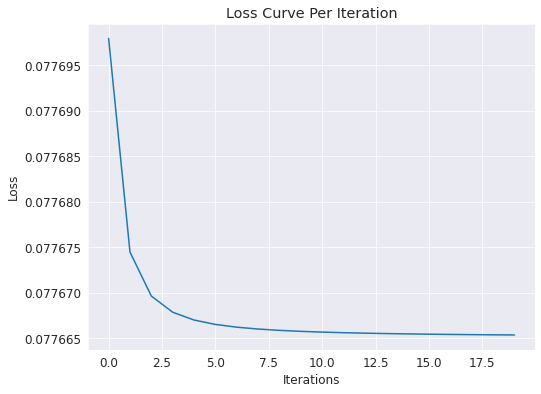

In [53]:
fm.__plot_learning_curves__()

### Predictions

In [54]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

idx_to_train_article_id = {i: article for i, article in enumerate(np.unique(train_df.article_id))}

# Generate 12 suggestions for a user-products matrix
def generate_suggestions(model, matrix, n = 12):
    proba = model.predict_proba(matrix)
    index = pd.DataFrame(proba, columns=['No', 'Yes']).sort_values('Yes', ascending = False)[0:n]['Yes'].index
    value = pd.DataFrame(proba, columns=['No', 'Yes']).sort_values('Yes', ascending = False)[0:n]['Yes'].values
    #return index, value
    return [''.join('0' + str(idx_to_train_article_id[i])) for i in index]


# Generate submission
def submission(model, res_article, res_customer, customer_matrix):
    submission = {}
    for i in tqdm(range(len(res_customer))):
        customer_id = res_customer[i]
        customer_matrix = get_user_matrix(i)
        recommendations = generate_suggestions(model, res_article, customer_matrix, n = 12)
        submission[customer_id] = ' '.join('0' + str(x) for x in recommendations)  
    return submission

def display_articles(articles):
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 3
    for i, article in enumerate(articles[0:12]):
        path = 'data/h-and-m-personalized-fashion-recommendations/images/' + article[0:3] + '/' + article + '.jpg'
        if not os.path.isfile(path):
            continue
        fig.add_subplot(rows, columns, i + 1)
        img = mpimg.imread(path)
        plt.imshow(img)
    plt.show()

def get_user_matrix(customer_id, customers_df, transactions_df):
    n_rows = len(np.unique(train_df.article_id))
    
    customers_df = preprocess_customers_df(customers_df, transactions_df)
    
    # Create CSR matrix for customers
    rows = np.arange(n_rows)
    cols = [customers_id_to_idx[customer_id]] * n_rows
    data = np.ones(n_rows)
    csr_customers = sparse.csr_matrix((data, (rows, cols)), shape=(n_rows, len(customers_id_to_idx)))

    # Create CSR matrix for articles
    rows = np.arange(n_rows)
    cols = [articles_id_to_idx[article] for article in np.unique(train_df.article_id)]
    data = np.ones(n_rows)
    csr_articles = sparse.csr_matrix((data, (rows, cols)), shape=(n_rows, len(articles_id_to_idx)))
    
    
    #todo: Create CSR matrix for article features
    rows = np.arange(n_rows)
    cols = np.array([articles_index_group_to_index[articles_df[articles_df.article_id==article].index_group_no.values[0]] for article in np.unique(train_df.article_id)])
    data = np.ones(len(rows))
    csr_articles_feature = sparse.csr_matrix((data, (rows, cols)), shape=(len(rows), len(articles_index_group_to_index)))

    customer_data = customers_df[customers_df['customer_id'] == customer_id].iloc[0]        
    
    # Concatenate matrices in CSR format
    sparse_matrix = sparse.hstack((csr_customers, csr_articles,csr_articles_feature), format='csr')
    # Age
    sparse_matrix = hstack((sparse_matrix, [[customer_data['age']]] * n_rows), format='csr')
    # Active
    sparse_matrix = hstack((sparse_matrix, [[customer_data['Active']]] * n_rows), format='csr')
    # Club member status
    sparse_matrix = hstack((sparse_matrix, [[customer_data['club_member_status']]] * n_rows), format='csr')
    # Common postal code
    sparse_matrix = hstack((sparse_matrix, [[customer_data['common_postal_code']]] * n_rows), format='csr')
    
    return sparse_matrix

In [55]:
preprocessed_customers_df = preprocess_customers_df(customers_df, transactions_df)

def get_random_recommendations(n=5):
    counter = 0
    while counter < n:
        customer_id = customers_df.iloc[np.random.randint(0, len(customers_df))]['customer_id']
        customer_info = preprocessed_customers_df.loc[preprocessed_customers_df.customer_id == customer_id]
        if len(customer_info) == 0:
            continue
        print("Customer info:")
        print(customer_info.iloc[0])
        user_matrix = get_user_matrix(customer_id, customers_df, transactions_df)
        recommendations = generate_suggestions(fm, user_matrix)
        print("Previously bought")
        display_articles(['0' + str(article) for article in train_df.loc[train_df.customer_id == customer_id]['article_id'].values])
        print("Recommendations")
        display_articles(recommendations)
        counter += 1

In [56]:
get_random_recommendations(n=5)

Customer info:
customer_id           61a3bca367efa313d8e6e0915b32d8f92248f611a721ce...
Active                                                                1
club_member_status                                                    0
age                                                                  27
common_postal_code                                                    0
article_id                                                    781613006
index_group_no                                                        1
Name: 80775, dtype: object
Previously bought


<Figure size 576x576 with 0 Axes>

Recommendations


<Figure size 576x576 with 0 Axes>

Customer info:
customer_id           8f6ef0d37f740c11957173ca2464d6f5c3ea66f6b9371a...
Active                                                                1
club_member_status                                                    0
age                                                                  23
common_postal_code                                                    0
article_id                                                    838340003
index_group_no                                                        2
Name: 292391, dtype: object
Previously bought


<Figure size 576x576 with 0 Axes>

Recommendations


<Figure size 576x576 with 0 Axes>

Customer info:
customer_id           524702ebd7762bcf4a2649347d5e0be502c083f2fb6994...
Active                                                                1
club_member_status                                                    0
age                                                                  49
common_postal_code                                                    0
article_id                                                    914441005
index_group_no                                                        2
Name: 29328, dtype: object
Previously bought


<Figure size 576x576 with 0 Axes>

Recommendations


<Figure size 576x576 with 0 Axes>

Customer info:
customer_id           ccbeeb5b7312fdeba414feae3e3fdd45f32f0d7f089f6d...
Active                                                                1
club_member_status                                                    0
age                                                                  52
common_postal_code                                                    0
article_id                                                    470789001
index_group_no                                                        1
Name: 462813, dtype: object
Previously bought


<Figure size 576x576 with 0 Axes>

Recommendations


<Figure size 576x576 with 0 Axes>

Customer info:
customer_id           a852ac0a6dc0cc288541533a17677e3235c8f73b51835e...
Active                                                                1
club_member_status                                                    0
age                                                                  47
common_postal_code                                                    0
article_id                                                    791587001
index_group_no                                                       26
Name: 51832, dtype: object
Previously bought


<Figure size 576x576 with 0 Axes>

Recommendations


<Figure size 576x576 with 0 Axes>

## Validation

In [150]:
val_df = pd.read_csv("data/validation_sm.csv")
val_df = val_df[['customer_id','article_id']]

In [153]:
val_df = val_df.loc[val_df.article_id.isin(get_most_bought_articles(transactions_df, num_articles=10))]

In [75]:
def get_predictions(customers):
    all_recommendations = []
    for customer_id in tqdm(customers):
        customer_info = preprocessed_customers_df.loc[preprocessed_customers_df.customer_id == customer_id]
        if len(customer_info) == 0:
            recommendations = get_popularity_based_prediction(customer_id)
        else:
            user_matrix = get_user_matrix(customer_id, customers_df, transactions_df)
            recommendations = generate_suggestions(fm, user_matrix)
        all_recommendations.append(recommendations)
    return pd.DataFrame({'customer_id': customers, 'prediction': all_recommendations})

- train 데이터에 구매 이력이 있는 고객에 대하여 ground truth 데이터를 생성한다

In [155]:
preprocessed_customers_df = preprocess_customers_df(customers_df, transactions_df)

targets = val_df.groupby('customer_id')['article_id'].apply(set)
targets_sample = targets[targets.apply(lambda x: len(x) > 12)]
targets_sample = targets_sample.apply(list)
targets_sample = targets_sample[targets_sample.index.isin(preprocessed_customers_df.customer_id)]

In [117]:
val_df[val_df.article_id==889703001]

,customer_id,article_id
24853,f3e3bacbbdd44d1bda47b4c5f61d291dc2d0e090cebc9e...,889703001
63475,40f4665fe26a4cb838700ae15ff60bc89f491732f944af...,889703001
70437,6c633d44d18f0517dc3774b0cb07d8c88c971032ed167b...,889703001
70438,6c633d44d18f0517dc3774b0cb07d8c88c971032ed167b...,889703001
70439,6c633d44d18f0517dc3774b0cb07d8c88c971032ed167b...,889703001
117358,98e6d2f440e7b29dc139b2e911f41adc1f814e09f16aca...,889703001
147283,6280a61cc380a4175adfb1a589802ad409e3451aa353c4...,889703001
156638,a29a5dbccd49c032bbf2ccf30ab2fa618b0856aa3d9d9c...,889703001
175672,2fb3a79f9f42da414c18f4f99f7e457de7e07c05eb474b...,889703001
178490,45ad973f2b97b0872f00871c5ac6f4cfdc74c124ef734c...,889703001


In [76]:
predictions = get_predictions(targets_sample.index[:200])

100%|██████████| 200/200 [43:00<00:00, 12.90s/it]


- calculate map@12

- 추천결과가 상당히 유사하게 나왔지만 완전히 일치하는 추천 순서는 한 건으로 보인다

In [157]:
predictions.set_index('customer_id').applymap(str).drop_duplicates(subset='prediction')

,prediction
customer_id,
00077dbd5c4a4991e092e63893ccf29294a9d5c46e85010e95f2fc10bf9437a4,"['0862325004', '0889703001', '0860657004', '08..."
0071db058be38eb5732a431d01137b2dbae5643ee60ffd9cb1280dc7308c9edf,"['0889703001', '0862325004', '0854043007', '08..."
0073569a706784581f7916cbc61e6af44c9fa52eae38e40520ae092f379a7232,"['0889703001', '0862325004', '0860657004', '08..."
0091bb09e49f45bdaeb3dd80f7bf98b4b8e3e3e49347e6bc9ec9818d631dddee,"['0889703001', '0862325004', '0860657004', '08..."
00944aac87d67eb28bb5d3b5dc02dafa6b34c821ff6a3b788360da7e864703a5,"['0889703001', '0862325004', '0860657004', '08..."
...,...
22353dac1f405922bd4731272d8dfa0b5ab77a9873c7a622a63e17dd30ad9cf7,"['0889703001', '0862325004', '0860657004', '08..."
2239f080b0ea938d574bc44d9b5ae21a80bd7d4bbfd1b5b1e570c78d388560b2,"['0889703001', '0862325004', '0860657004', '08..."
225294df47a93bacb496ed327894d33e6aa2ac088d62ca03d18124f8f375e76a,"['0889703001', '0862325004', '0854043007', '08..."


In [127]:
print(predictions.iloc[0].prediction[0])
type(predictions.iloc[0].prediction[0])
print(int(predictions.iloc[0].prediction[0]))

0862325004
862325004


In [128]:
print(targets_sample.iloc[0][0])
type(targets_sample.iloc[0][0])

158340001


int

In [159]:
# 데이터 포맷이 다른 prediction 과 target 각각을 비교하기 위한 처리를 추가함

def apk(y_true, y_pred, k_max=0):
    y_true = list(set(y_true))
    y_pred = list(set(y_pred))
    y_pred = list(map(int, y_pred))
    if k_max != 0:
        y_pred = y_pred[:k_max]

#     print("y_true: ", y_true)
#     print("y_pred: ", y_pred)
#     print("\n")
    correct_predictions = 0
    running_sum = 0

    for i, yp_item in enumerate(y_pred):
    
        k = i+1 # our rank starts at 1
    
    if yp_item in y_true:
        correct_predictions += 1
        running_sum += correct_predictions/k

    return running_sum/len(y_true)

def mapk(actuals, predicted, k=12):
    apks = [apk(a,p,12) for a,p in zip(actuals,predicted)]
#     print(apks)
    return np.mean(apks)

In [148]:
articles_df[articles_df.article_id == 889703001]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
100345,889703001,889703,1pk Short sock,302,Socks,Socks & Tights,1010017,Stripe,10,White,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a cotton blend with a ribbed, ankle-h..."


- 기대하는 MAP@12 퍼포먼스는 나오지 않았다. sample이 잘 못된 것인지 의심된다.

In [160]:
mapk(targets_sample.iloc[:200],predictions.iloc[:200].prediction)

1.2254901960784313e-05

- prediction 자체가 잘 되지 않았을 지도 모른다는 생각이 들었음.

In [167]:
predictions

,customer_id,prediction
0,c6e17100a6160eab7230db435648786ec751de99394d74...,"[0889703001, 0862325004, 0860657004, 088872800..."
1,c721e80543288bebcf0f032f34ff35c77a261a402dd83c...,"[0889703001, 0862325004, 0860657004, 088872800..."
2,c80e4f76fed1b48c904da30d16887b29abc8abd991938b...,"[0889703001, 0862325004, 0889771002, 085404300..."
3,c851e42599f3bc0d28dbb0cdfbe66e311bab3136c70930...,"[0889703001, 0862325004, 0860657004, 085404300..."
4,c88057ce9c0c9ddba7e125802e3ece063d33377ba1c968...,"[0889703001, 0862325004, 0860657004, 086210400..."
...,...,...
51,fa2d2a86a162355ddf58407e9be5d9b59e57b66db5d024...,"[0889703001, 0862325004, 0860657004, 085404300..."
52,faeaa958e35637fda7ada8118155e3531bb5d3529ff562...,"[0889703001, 0862325004, 0888728006, 086065700..."
53,fb16e817d250e2b6af03a6daa167a23b5234f409c25835...,"[0889703001, 0862325004, 0860657004, 085404300..."
54,fbfe4aee61999aeca4c616f9d46ee67d8d144bbecbff59...,"[0889703001, 0862325004, 0860657004, 088872800..."


In [166]:
predictions = get_predictions(targets_sample.index[200:300])

100%|██████████| 56/56 [12:13<00:00, 13.10s/it]


- 역시 MAP@12 스코어가 나쁘다.

In [171]:
mapk(targets_sample.iloc[200:300],predictions.prediction)

0.0

In [162]:
#transactions_df.to_csv("transactions_sm.csv",index=False)

In [163]:
#customers_df.to_csv("customers_sm.csv",index=False)

In [164]:
#articles_df.to_csv("articles_sm.csv",index=False)

In [165]:
#val_df.to_csv("validation_sm.csv",index=False)